# Tree Classes

In this notebook we are going to take a look at some of the methods and classes available for fooling around with phylogenetic trees. I basically started out by building a `PhyloTree` class, and then a `ResolvedTree` class, and finally building this into a `ParameterizedTree` class. 

These all are built to work around the data as I constructed in an earlier workbook. 

Anyways, let's just pull in a class and see what can be done with it. In a subsequent workbook, we will think about applying maximum likelihood methods, estimating trees, forming distributions over trees, etc. 

As usual, the first thing to do is get all our modules up and running and installed. Here goes:

In [1]:
# My modules

import PyIETools
import PyIEClasses

# Other modules needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mplleaflet
import re

from scipy.optimize import minimize

# Import all the routines that I have written.

%matplotlib inline
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Reading in the data
# Read in the Pickle files

Data=pd.read_pickle('IEData\\MasterData.pkl')
Splits=pd.read_pickle('IEData\\Splits.pkl')
Depths=pd.read_pickle('IEData\\Depths.pkl')

## Khoisan Language Tree

The first thing we are going to do is take a look at the Khoisan Language tree and what can be done with it. We are also going to add a little fictional information to the tree - i.e., deaden some branches - mainly just to see how our methods are working in this regard. So, let's suppose that the **Nama** branch and the **Gwi** branch expired in the year 1500, and the year 100 respectively. Then:

In [2]:
Data['ex_date'].loc[Data['name']=='NAMA']=1500
Data['ex_date'].loc[Data['name']=='GWI']=100
Data['deadOne'].loc[Data['name']=='NAMA']=0
Data['deadOne'].loc[Data['name']=='GWI']=0

C:\Users\Matthew Baker\Anaconda3\lib\site-packages\pandas\core\indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


We seek to set up and parameterize a complete tree. To this end, we have to add some branching parameters to the tree (one for each internal branch), and we also need to add transition rate parameters to the tree - one for each word. We then need an overall depth parameter, and a parameter for each dead branch. The easiest way to initialize all of this information is to count the internal branches, dead spots, and words using utilities from `PyIETools`:






In [3]:
KhoisanRT = PyIEClasses.ResolvedTree(Data.loc[Data['ruhlen_1'] == 'KHOISAN'], 'KTree1') #Create a resolved tree
numbranches = KhoisanRT.interiorbranches                                                #Get no. of interior branches
bInit       = np.matrix(- 1 - np.linspace(0,10,num=numbranches)/numbranches)            #Make a conformable set of parameters
rInit       = np.zeros((1, len(KhoisanRT.words)))                                       #initial rate parameters
dparms      = np.sum(KhoisanRT.deathmat[:,0] == 0)                                      #Number of death parameters needed
dInit       = np.zeros((1, dparms)) + 1                                                 #Values for death parameters
eInit       = np.matrix(5)                                                              #Overall depth parameter
parmsInit   = np.hstack((bInit, rInit, dInit, eInit))                                   #Stack them all together

Next, the parameters can be passed to the class initiator, along with the requisite data frame slices, and a name for the tree. 

In [4]:
KhoisanPT=PyIEClasses.ParameterizedTree(Data.loc[Data['ruhlen_1']=='KHOISAN'],'KTree1',parmsInit)

Include prior information on the depth of the tree, and also the information on splits. The `settimes()` class method translates parameters into times. So, we have:

In [5]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'Khoisan'])
max = np.array(Depths['max'].loc[Depths['phylum'] == 'Khoisan'])
KhoisanPT.priordepth(min,max)
KhoisanPT.splitinfo(Splits[Splits['phylum'] == 'Khoisan'])
KhoisanPT.settimes()
print(type(min))

<class 'numpy.ndarray'>


## Exploring the Tree

We are now in a position to take a look at the tree, see its attributes, what it implies for points of origin, etc. One useful class method in this regard is the `showtree()` method, which plots out a phylogenetic picture of the tree (with branches proportioned accordingly and all that). Here it is for our tree:

<IPython.core.display.Javascript object>


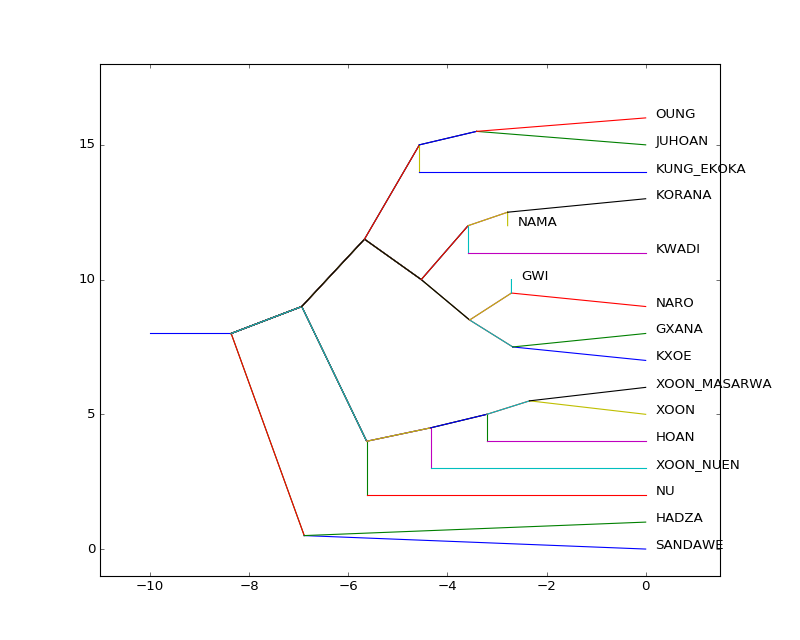

In [6]:
KhoisanPT.showtree()

In [7]:
KhoisanPT.RouteChooser()
KhoisanPT.TimeInPlace()

<IPython.core.display.Javascript object>


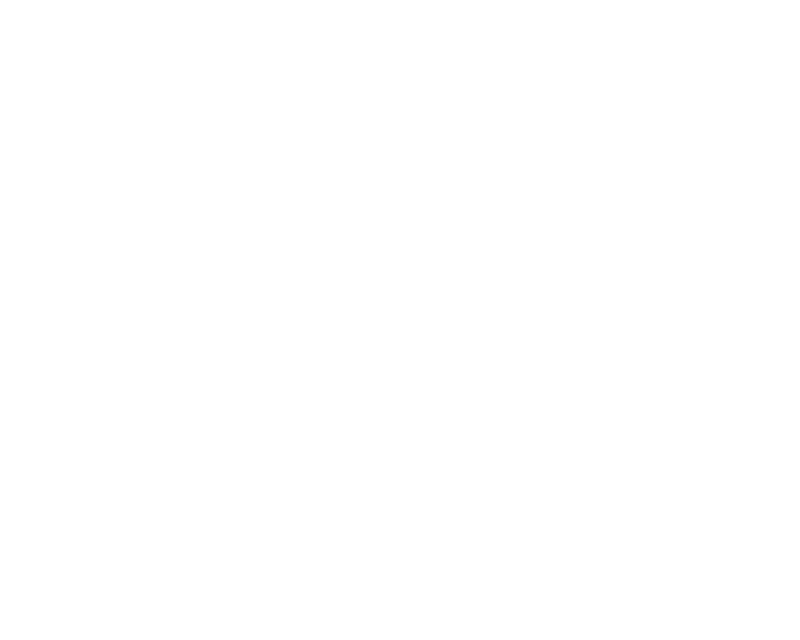

In [13]:
TimePlace = []
for i in range(0, PyIETools.rows(KhoisanPT.Path)):
    firstAppearance = np.where(KhoisanPT.Path[i,:] == i)[0]
    if (len(firstAppearance) > 0):
        TimePlace.append(firstAppearance[0])
    else:
        TimePlace.append(-1)
TimeInPlace = []
for i in range(0, PyIETools.rows(KhoisanPT.Path)):
    toAdd = np.nansum(KhoisanPT.filledtimeFractions[i,TimePlace[i]:])
    TimeInPlace.append(toAdd)
    
y = np.asarray(KhoisanPT.lat.astype(float)).flatten().tolist()
x = np.asarray(KhoisanPT.lon.astype(float)).flatten().tolist()
name = np.asarray(KhoisanPT.name).flatten().tolist()

s = [3*100*n for n in TimeInPlace]

Order=np.array(KhoisanPT.resolvedtree[:,-1].astype(int)).flatten()

y=[y[i] for i in Order]
x=[x[i] for i in Order]

Order=Order.flatten()

myfig = plt.figure()
mypic = myfig.add_subplot(111)
mypic.scatter(x, y, c=s, s=s, cmap="Reds")

# Not working...a better approach might be to handle this differently.
for i, txt in enumerate(name):
    mypic.annotate(name[i], (x[i], y[i]))

mplleaflet.display()